This is the notebook to use to generate a figure. 
For this, you need to have to have the following: 
- the real dataset (cme)
- the set `.env` at the root with `$WORKSPACE` and `$DEMAPPER`

## Step 1) run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of DeMapper configurations (they will run for a while):

```
./code/utils/run_mapper.sh --poolsize 4 mappers_cme_dists1.json cme

./code/utils/run_mapper.sh --poolsize 8 mappers_cme_dists2.json cme

```


## Step 2) Analyze the created Mappers graphs (delay times, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the delay times criteria and the other statistics:


```
CONF=mappers_cme_dists1.json
CONF=mappers_cme_dists2.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
DATAFOLDER="$WORKSPACE/results/cme/${CONF}/"
FN_TIMING="$WORKSPACE/data/cme/timing.csv"
OUTPUT_DIR="$WORKSPACE/results/cme/analysis/${CONF}/"
STAT_TYPE="compute_degrees_from_TCM"
CHANGE_POINTS=10
HAS_INSTRUCTIONS=1;
ARGS="datafolder='${DATAFOLDER}'; fn_timing='${FN_TIMING}'; output_dir='${OUTPUT_DIR}'; stat_type='${STAT_TYPE}';"
ARGS="$ARGS HAS_INSTRUCTIONS=${HAS_INSTRUCTIONS}; CHANGE_POINTS=${CHANGE_POINTS};"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/cme/deg_analysis_sbjs.m')"
```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/cme/shine/cohort.csv \
    $WORKSPACE/results/cme/${CONF}/ \
    --output_dir $WORKSPACE/results/cme/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 3) Generate the figures

In [1]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image
from scipy import stats

sns.set(rc={'figure.facecolor':'white'})

# demapper imports for the analysis
from demapper.code.utils.analyze import extract_dataset, _handle_list_cols
from demapper.code.utils.config_cme import DATASETS, FILTERS
from demapper.code.utils.config_mapper import extract_params_f
from demapper.code.utils.utils import filter_dataframe, count_passing

### Figure (a)

Run the following script:

```
CONF=mappers_cme_dists1.json
source .env
# module load matlab # Maybe run this if you are running in SLURM
FN_TIMING="$WORKSPACE/data/cme/timing.csv"
RES_PATH="$WORKSPACE/results/cme/analysis/${CONF}/"
CHANGE_POINTS=10
ARGS="fn_timing='${FN_TIMING}'; res_path='${RES_PATH}'; CHANGE_POINTS=${CHANGE_POINTS};"
for MAPPER in DistsGeoBDLMapper_euclidean DistsGeoBDLMapper_cityblock DistsGeoBDLMapper_chebychev DistsGeoBDLMapper_correlation DistsBDLMapper_euclidean DistsBDLMapper_correlation
do
    matlab -nodesktop -r "${ARGS} mapper_name='${MAPPER}'; run('$WORKSPACE/code/cme/plots_for_fig6.m'); exit;"
done
```

The plots are now generated

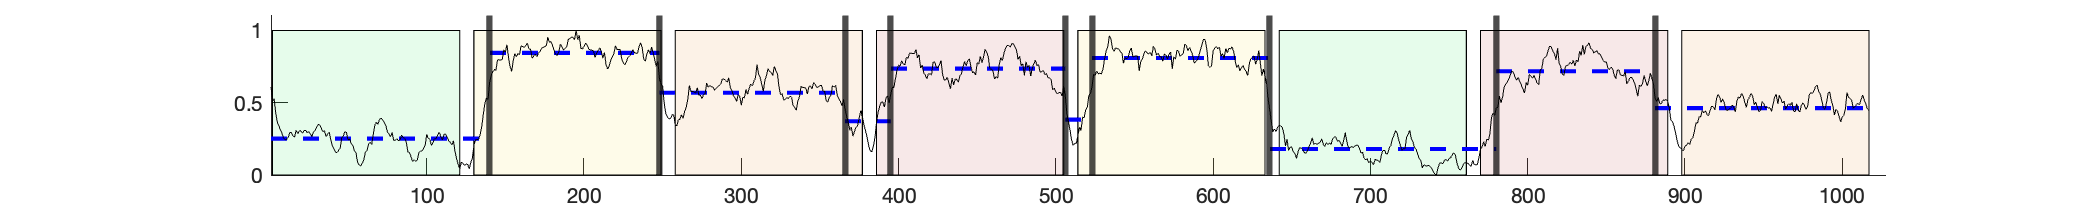

In [2]:
imgpath = 'results/cme/analysis/mappers_cme_dists1.json/change-degs_DistsGeoBDLMapper_euclidean.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

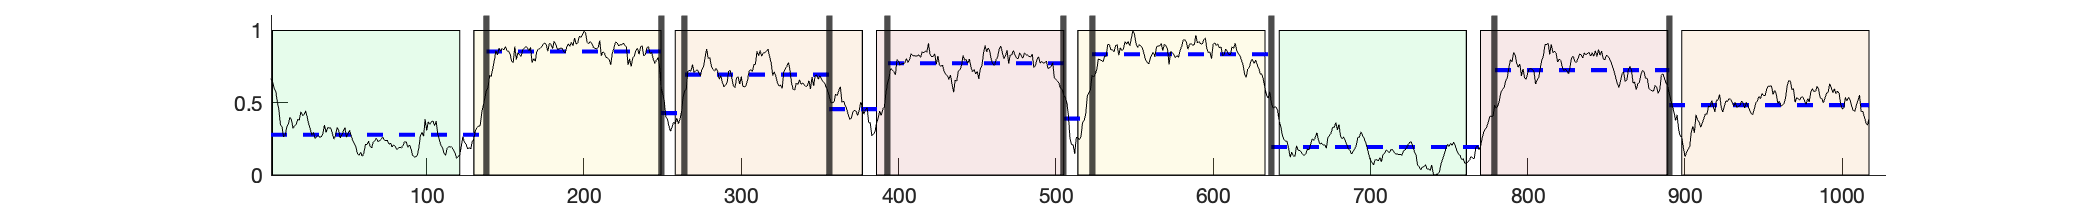

In [3]:
imgpath = 'results/cme/analysis/mappers_cme_dists1.json/change-degs_DistsGeoBDLMapper_cityblock.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

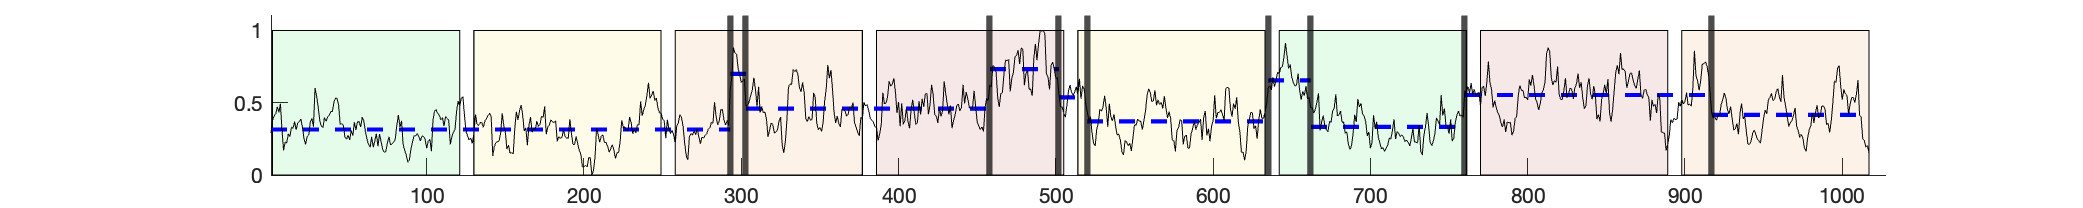

In [4]:
imgpath = 'results/cme/analysis/mappers_cme_dists1.json/change-degs_DistsGeoBDLMapper_correlation.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

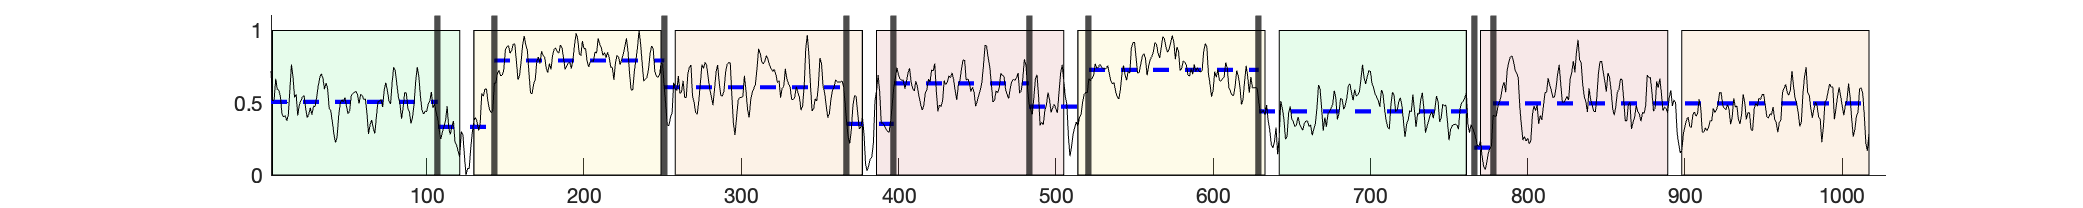

In [5]:
imgpath = 'results/cme/analysis/mappers_cme_dists1.json/change-degs_DistsBDLMapper_euclidean.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

### Figure (b)

In [6]:
PICKED_DATASET = 'cme-dists2'
dists = ['euclidean', 'cityblock', 'chebychev', 'cosine', 'correlation']
TYPE='compute_degrees_from_TCM'
ChangePointsError_limit = 12

datadir = DATASETS[PICKED_DATASET]

target_metrics_limits = {
    'ChangePointsIndicesError': [0, ChangePointsError_limit],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}

stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))

# Extract geodesic distances mappers
df_geo, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][0], extract_params_f, has_sbj=False)
df_nongeo, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][1], extract_params_f, has_sbj=False)

Kvals = sorted(df_geo['K'].drop_duplicates().to_numpy())

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    for k in Kvals:
        fdf = filter_dataframe(df_geo, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits)
        table.append({
            'Distance type': dist,
            'K': k,
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'len': len(fdf),
            'geodesic': True,
        })
        
    fdf = filter_dataframe(df_nongeo, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits)
    table.append({
        'Distance type': dist,
        'count': cnt,
        'perc': cnt / len(fdf) * 100.0,
        'len': len(fdf),
        'geodesic': False,
    })

counts_df = pd.DataFrame(data=table)

sns.set(style = "whitegrid")
plt.figure(figsize=(3,5))
ax = sns.boxplot(
    data=counts_df[counts_df['geodesic'] == True], x='Distance type', y='perc', color=[0.6,1.0,0])
ax = sns.swarmplot(
    data=counts_df[counts_df['geodesic'] == False], x='Distance type', y='perc',
    color=[1.0,0.0,1.0], marker="X", size=8, ax=ax, alpha=0.8)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=70)
plt.ylim([-5, 100])
plt.grid(axis='y', alpha=0.3)
plt.xlabel('')
plt.ylabel('Percentage delay < {} seconds'.format(ChangePointsError_limit))
plt.tight_layout()

# plt.show()
save_path = os.path.join(datadir, 'distances_DistsMappers.png')
plt.savefig(save_path, dpi=300)
plt.close()

len(stats):  4125
len(results):  4125
len(stats):  4125
len(results):  4125


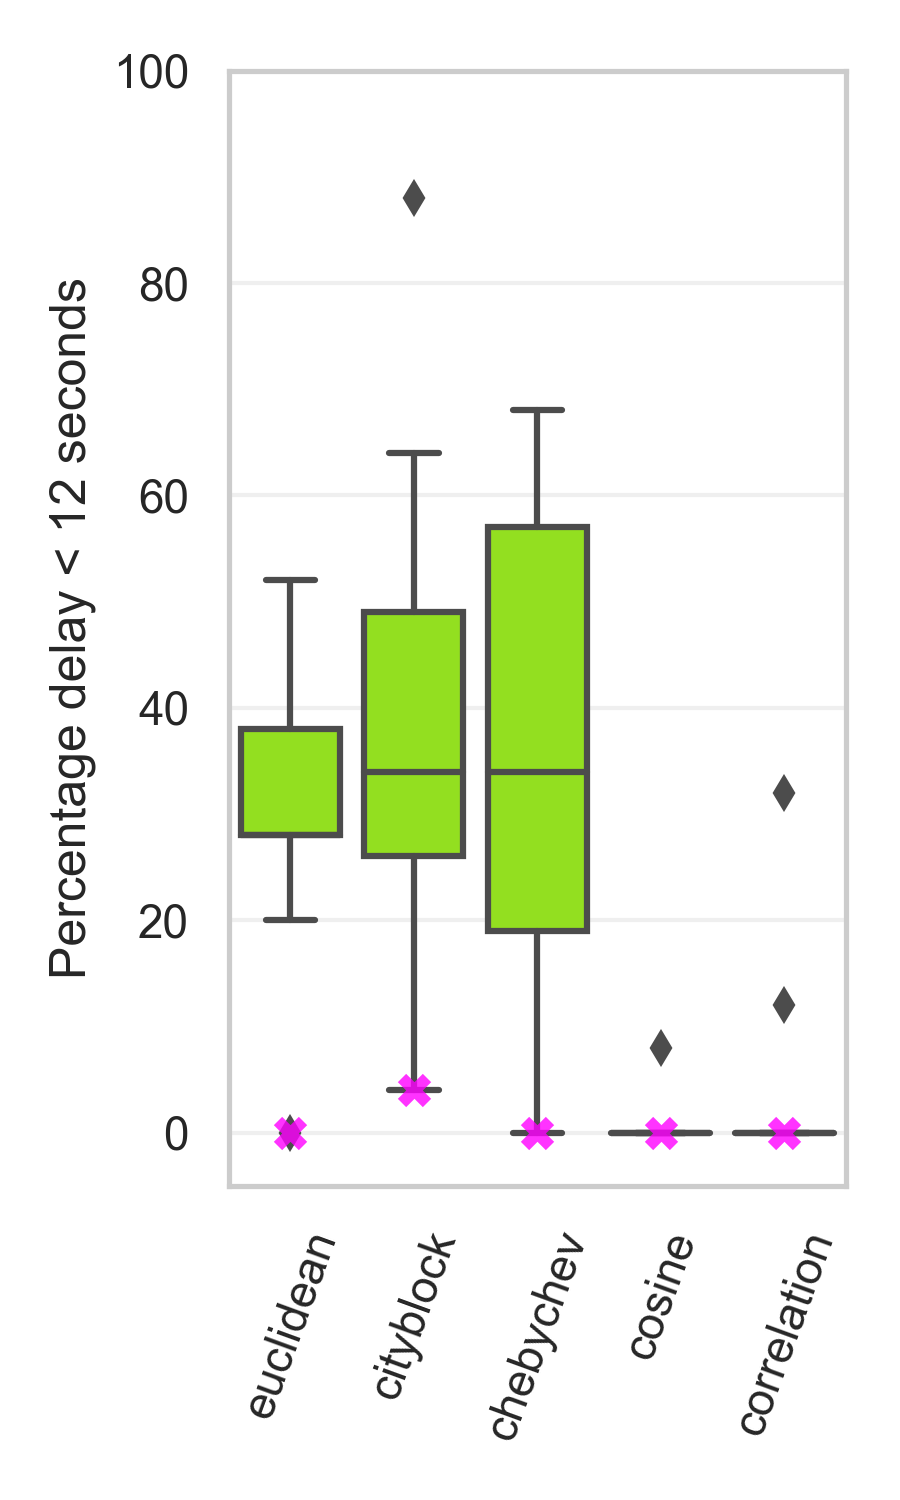

In [7]:
imgpath = 'results/cme/analysis/mappers_cme_dists2.json/distances_DistsMappers.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [8]:
fdf = counts_df.copy()
buckets = fdf['Distance type'].drop_duplicates().tolist()
print('ANOVA', stats.f_oneway(*[fdf[fdf['Distance type'] == b]['perc'].tolist() for b in buckets]))

ANOVA F_onewayResult(statistic=17.642343924636762, pvalue=2.0400558563038019e-10)


In [9]:
magn_metrics = ['euclidean', 'cityblock', 'chebychev']
angl_metrics = ['cosine', 'correlation']

p1 = counts_df[counts_df['Distance type'].isin(magn_metrics)]['perc'].tolist()
p2 = counts_df[counts_df['Distance type'].isin(angl_metrics)]['perc'].tolist()
stats.ttest_ind(p1, p2)

Ttest_indResult(statistic=8.415347649018841, pvalue=9.652946686817623e-13)

In [10]:
fdf = counts_df[counts_df['Distance type'].isin(magn_metrics)]
buckets = fdf['Distance type'].drop_duplicates().tolist()
print('ANOVA', stats.f_oneway(*[fdf[fdf['Distance type'] == b]['perc'].tolist() for b in buckets]))

ANOVA F_onewayResult(statistic=0.351935646053293, pvalue=0.7051249850413805)


In [11]:
p1d = counts_df[counts_df['geodesic'] == True].groupby('Distance type')['count'].mean().to_dict()
p2d = counts_df[counts_df['geodesic'] == False].groupby('Distance type')['count'].mean().to_dict()
ds = p1d.keys()
stats.ttest_rel([p1d[d] for d in ds], [p2d[d] for d in ds])

Ttest_relResult(statistic=2.6393995346622408, pvalue=0.05761654697528295)

### Supplementary figures

#### Higher threshold for accepting delays

In [12]:
PICKED_DATASET = 'cme-dists2'
dists = ['euclidean', 'cityblock', 'chebychev', 'cosine', 'correlation']
TYPE='compute_degrees_from_TCM'
ChangePointsError_limit = 20

datadir = DATASETS[PICKED_DATASET]

target_metrics_limits = {
    'ChangePointsIndicesError': [0, ChangePointsError_limit],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}

stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))

# Extract geodesic distances mappers
df_geo, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][0], extract_params_f, has_sbj=False)
df_nongeo, _ = extract_dataset(stats_path, results_path, FILTERS[PICKED_DATASET][1], extract_params_f, has_sbj=False)

Kvals = sorted(df_geo['K'].drop_duplicates().to_numpy())

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    for k in Kvals:
        fdf = filter_dataframe(df_geo, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits)
        table.append({
            'Distance type': dist,
            'K': k,
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'len': len(fdf),
            'geodesic': True,
        })
        
    fdf = filter_dataframe(df_nongeo, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits)
    table.append({
        'Distance type': dist,
        'count': cnt,
        'perc': cnt / len(fdf) * 100.0,
        'len': len(fdf),
        'geodesic': False,
    })

counts_df = pd.DataFrame(data=table)

sns.set(style = "whitegrid")
plt.figure(figsize=(3,5))
ax = sns.boxplot(
    data=counts_df[counts_df['geodesic'] == True], x='Distance type', y='perc', color=[0.6,1.0,0])
ax = sns.swarmplot(
    data=counts_df[counts_df['geodesic'] == False], x='Distance type', y='perc',
    color=[1.0,0.0,1.0], marker="X", size=8, ax=ax, alpha=0.8)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=70)
plt.ylim([-5, 100])
plt.grid(axis='y', alpha=0.3)
plt.xlabel('')
plt.ylabel('Percentage delay < {} seconds'.format(ChangePointsError_limit))
plt.tight_layout()

# plt.show()
save_path = os.path.join(datadir, 'distances_DistsMappers_th{}.png'.format(ChangePointsError_limit))
plt.savefig(save_path, dpi=300)
plt.close()

len(stats):  4125
len(results):  4125
len(stats):  4125
len(results):  4125


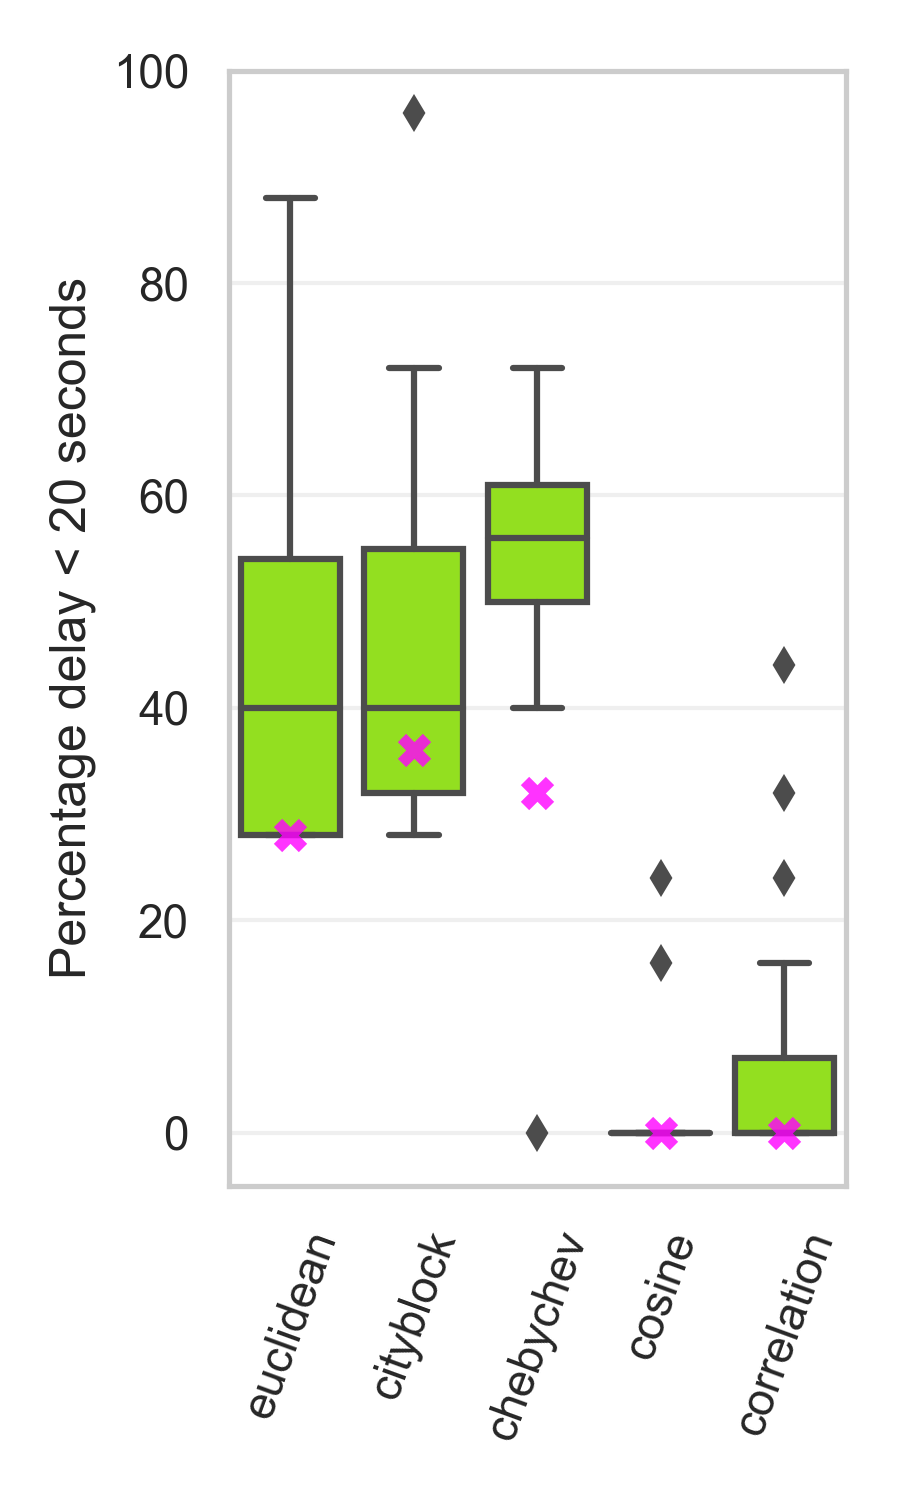

In [13]:
imgpath = 'results/cme/analysis/mappers_cme_dists2.json/distances_DistsMappers_th20.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [14]:
fdf = counts_df.copy()
buckets = fdf['Distance type'].drop_duplicates().tolist()
print('ANOVA', stats.f_oneway(*[fdf[fdf['Distance type'] == b]['perc'].tolist() for b in buckets]))

ANOVA F_onewayResult(statistic=39.30713587487778, pvalue=3.601028429044191e-18)


In [15]:
magn_metrics = ['euclidean', 'cityblock', 'chebychev']
angl_metrics = ['cosine', 'correlation']

p1 = counts_df[counts_df['Distance type'].isin(magn_metrics)]['perc'].tolist()
p2 = counts_df[counts_df['Distance type'].isin(angl_metrics)]['perc'].tolist()
stats.ttest_ind(p1, p2)

Ttest_indResult(statistic=12.360269867055521, pvalue=1.6427368872413784e-20)

In [16]:
fdf = counts_df[counts_df['Distance type'].isin(magn_metrics)]
buckets = fdf['Distance type'].drop_duplicates().tolist()
print('ANOVA', stats.f_oneway(*[fdf[fdf['Distance type'] == b]['perc'].tolist() for b in buckets]))

ANOVA F_onewayResult(statistic=1.0134301270417425, pvalue=0.37060542433272076)


In [17]:
p1d = counts_df[counts_df['geodesic'] == True].groupby('Distance type')['count'].mean().to_dict()
p2d = counts_df[counts_df['geodesic'] == False].groupby('Distance type')['count'].mean().to_dict()
ds = p1d.keys()
stats.ttest_rel([p1d[d] for d in ds], [p2d[d] for d in ds])

Ttest_relResult(statistic=3.588936677109699, pvalue=0.022983607877294015)

#### Intrinsic mapper

In [18]:
## Same distances analysis figure, but now for intrinsic mapper

# This figure is independent of the other code, except the imports

PICKED_DATASET = 'cme-dists2'
dists = ['euclidean', 'cityblock', 'chebychev', 'cosine', 'correlation']
TYPE='compute_degrees_from_TCM'
ChangePointsError_limit = 12

datadir = DATASETS[PICKED_DATASET]
filter_by = FILTERS[PICKED_DATASET][2] # <- same as dists2 but this filter_by is changed to be 2 instead of 0

target_metrics_limits = {
    'ChangePointsIndicesError': [0, ChangePointsError_limit],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}

stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))

# Extract geodesic distances mappers
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

Kvals = sorted(df_geo['K'].drop_duplicates().to_numpy())

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    for k in Kvals:
        fdf = filter_dataframe(df_geo, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits)
        table.append({
            'Distance type': dist,
            'K': k,
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'len': len(fdf),
        })

counts_df = pd.DataFrame(data=table)

# fdf = filter_dataframe(counts_df, {'K': [6, 8, 12, 16, 24, 32, 48, 64, 96, 128]})

sns.set(style = "whitegrid")
plt.figure(figsize=(3,5))
ax = sns.boxplot(data=counts_df, x='Distance type', y='perc', color=[0.6,1.0,0])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=70)
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)
plt.xlabel('')
plt.ylabel('Percentage delay < {} seconds'.format(ChangePointsError_limit))
plt.tight_layout()

# plt.show()
save_path = os.path.join(datadir, 'distances_{}.png'.format(filter_by))
plt.savefig(save_path, dpi=300)
plt.close()

len(stats):  4125
len(results):  4125


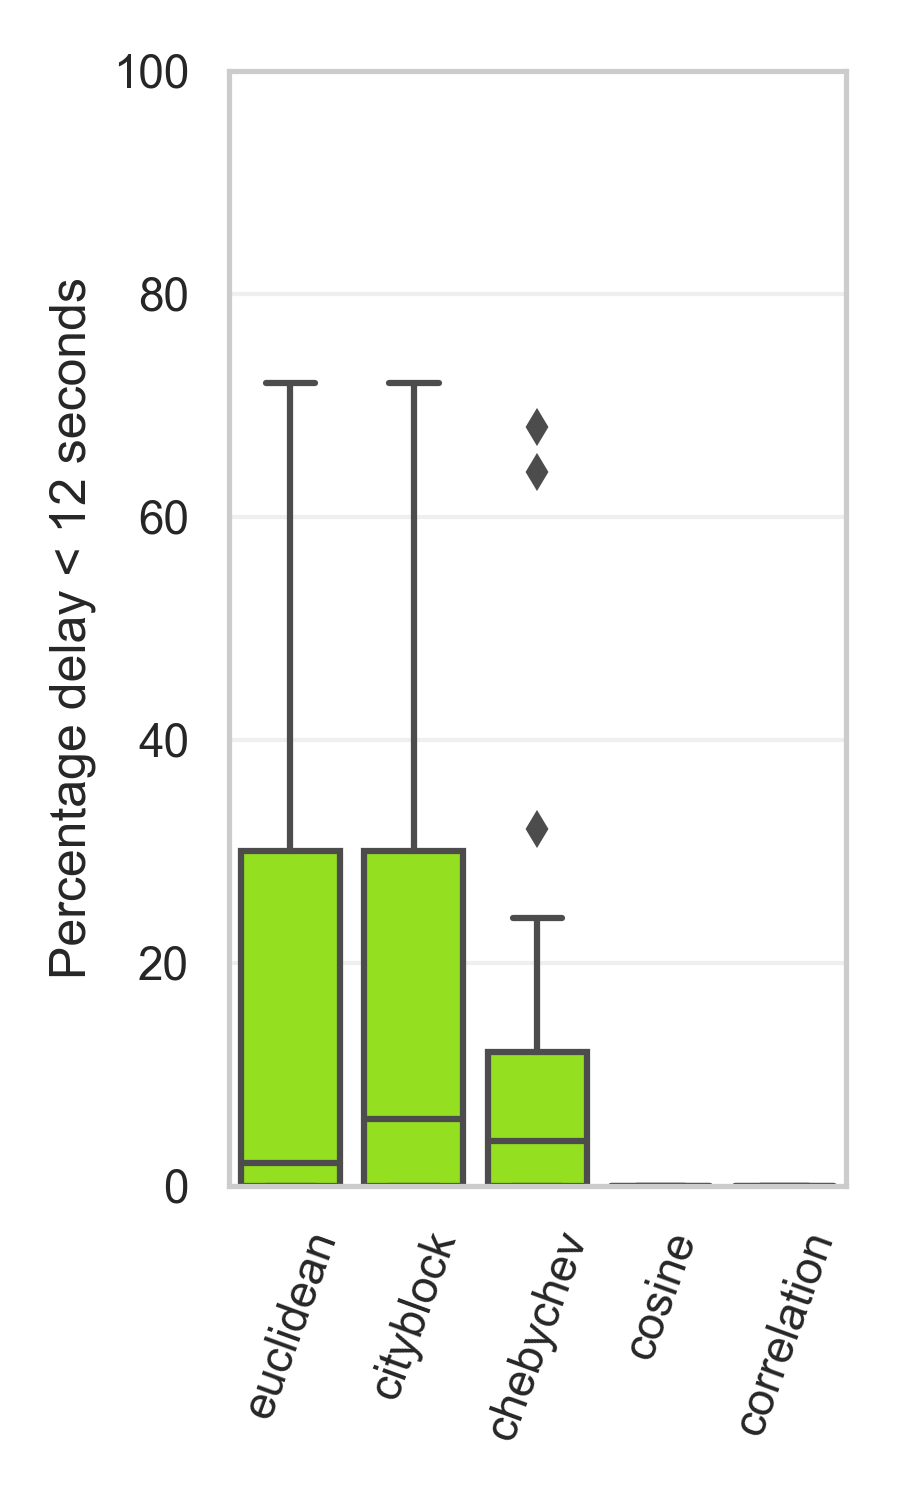

In [19]:
imgpath = 'results/cme/analysis/mappers_cme_dists2.json/distances_DistsGeoNeuMapper.png'
display(IPyImage(filename=os.path.join('../', imgpath)))